# imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from IPython.display import clear_output

import tqdm
from tqdm.notebook import tqdm as tqdm_notebook

import numpy as np

from copy import deepcopy

## Домашнее задание 1. Обучение LeNet

На прошлой лабораторной мы рассмотрели пример обучения небольшой нейронной сети для классификации датасета CIFAR-10. В качестве домашнего задания вам предлагается классификация предметов одежды из датасета [**Fashion MNIST**](https://pytorch.org/vision/main/generated/torchvision.datasets.FashionMNIST.html#torchvision.datasets.FashionMNIST). Вы можете начать с имплементации классической сверточной сети [LeNet](https://en.wikipedia.org/wiki/LeNet) и улучшить ее методами, которые мы обсудили на лекции (dropout, batchnorm, etc).

### Загрузка датасета

In [2]:
# Гиперпараметры
BATCH_SIZE = 128
EPOCHS = 40
torch.manual_seed(42);

In [3]:
def show_images_from_dataset(current_dataset, etalon_dataset):
    # Показать примеры картинок из датасета
    images = [current_dataset[i][0] for i in range(8)]
    images.extend([etalon_dataset[i][0] for i in range(8)])
    grid = make_grid(images, nrow=8)
    plt.figure(figsize=(15, 4))
    plt.imshow(grid.permute(1, 2, 0));

In [4]:
# Загрузка FashionMNIST
transform_train = transforms.Compose([
    transforms.ToTensor()
])
train_dataset = datasets.FashionMNIST(
    root='./train',
    train=True,
    download=True,
    transform=transform_train
)

transform_test = transforms.Compose([
    transforms.ToTensor()
])
test_dataset = datasets.FashionMNIST(
    root='./test',
    train=False,
    download=True,
    transform=transform_test
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

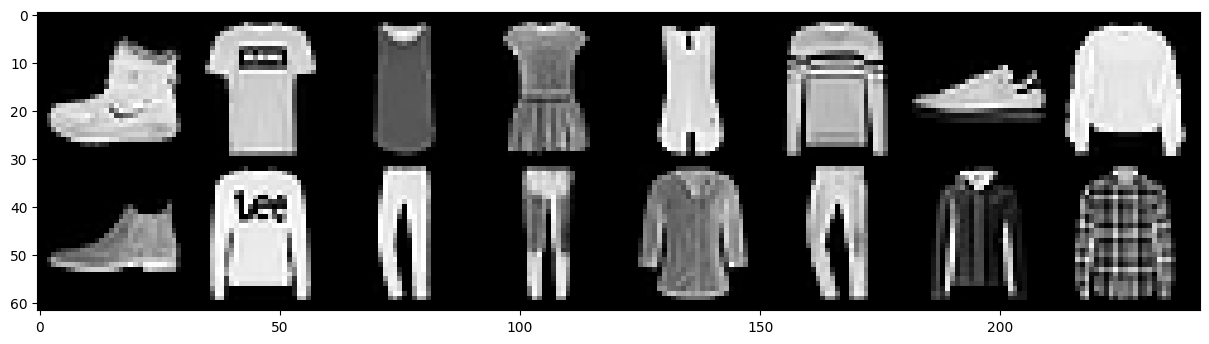

In [5]:
show_images_from_dataset(train_dataset, test_dataset)

In [6]:
# Расчет среднего и отклонения для нормализации
data = torch.cat([img for img, _ in train_dataset], dim=0)
mean = data.mean().item()
std = data.std().item()
print(f"Mean: {mean:.4f}, Std: {std:.4f}")

Mean: 0.2860, Std: 0.3530


In [7]:
# Загрузка FashionMNIST
transform_train_norm = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((mean,), (std,))
])
train_dataset_norm = datasets.FashionMNIST(
    root='./train_norm',
    train=True,
    download=True,
    transform=transform_train_norm
)

transform_test_norm = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((mean,), (std,))
])
test_dataset_norm = datasets.FashionMNIST(
    root='./test_norm',
    train=False,
    download=True,
    transform=transform_test_norm
)

train_loader_norm = DataLoader(train_dataset_norm, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_loader_norm = DataLoader(test_dataset_norm, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


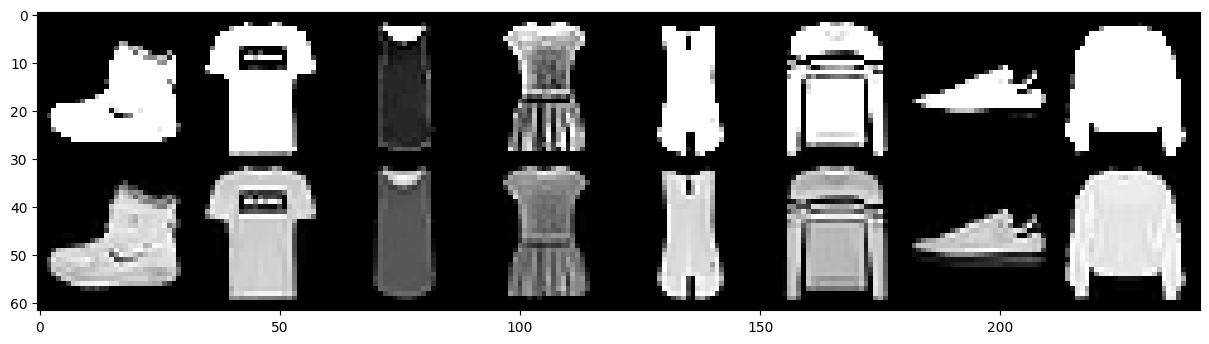

In [8]:
show_images_from_dataset(train_dataset_norm, train_dataset)

In [9]:
# Загрузка FashionMNIST
transform_train_aug = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Случайное отражение
    transforms.RandomVerticalFlip(),  # Случайное отражение
    transforms.RandomRotation(15),      # Поворот ±15 градусов
    transforms.ToTensor(),
    transforms.Normalize((mean,), (std,))
])
train_dataset_aug = datasets.FashionMNIST(
    root='./train_aug',
    train=True,
    download=True,
    transform=transform_train_aug
)

transform_test_aug = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((mean,), (std,))
])
test_dataset_aug = datasets.FashionMNIST(
    root='./test_aug',
    train=False,
    download=True,
    transform=transform_test_aug
)

train_loader_aug = DataLoader(train_dataset_aug, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_loader_aug = DataLoader(test_dataset_aug, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


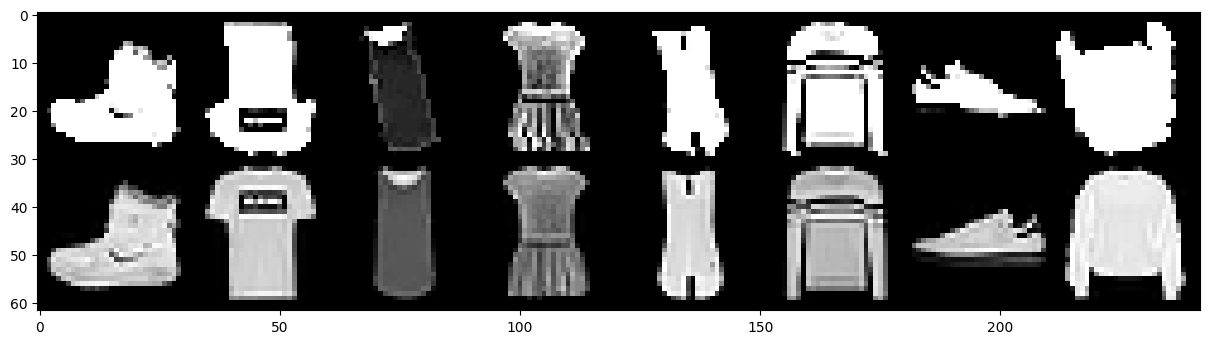

In [10]:
show_images_from_dataset(train_dataset_aug, train_dataset)

## Архитектура LeNet



### **Задание 1**: закончите имплементацию LeNet согласно диаграме сверху

In [11]:
class LeNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.flatten = nn.Flatten()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5, padding=2),   # [28x28x6]
            nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2),       # [14x14x6]
            nn.Conv2d(6, 16, kernel_size=5),             # [10x10x16]
            nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2)        # [5x5x16]
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(5*5*16, 120),                      # [120]
            nn.Sigmoid(),
            nn.Linear(120, 84),                          # [84]
            nn.Sigmoid(),
            nn.Linear(84, 10)                            # [10]
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.flatten(x)        # [400]  
        x = self.fc_layers(x)
        x = F.log_softmax(x, dim=1)        
        return x

### **Задание 2**: Напишите функцию обучения

Вы можете воспользоваться кодом из прошлой лабораторной работы

Посчитайте точность на валидационном сете. 

In [20]:
class LearningModel():
    def __init__(self, model, train_loader, test_loader, device='auto'):
        self.model = model
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.device = device

        # Определение устройства
        if device == 'auto':
            self.device_for_learning = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        elif device == 'cpu':
            self.device_for_learning = torch.device("cpu")
        elif device == 'cuda':
            self.device_for_learning = torch.device("cuda")
        else:
            raise ValueError("Invalid device choice. Use 'auto', 'cpu', or 'cuda'.")

    def plot_metrics(self, note) -> None:
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))
        train_loss, test_loss, train_acc, test_acc = self.metrics.values()

        axes[0].set_title(f'Train loss: {train_loss[-1]:.2f}, Test loss: {test_loss[-1]:.2f}')
        axes[0].plot(train_loss, label='Train_loss')
        axes[0].plot(test_loss, label='Test_loss')

        axes[1].set_title(f'Train acc: {train_acc[-1]:.2f}, Test acc: {test_acc[-1]:.2f}')
        axes[1].plot(train_acc, label='Train_acc')
        axes[1].plot(test_acc, label='Test_acc')

        legend = [ax.legend() for ax in axes]

        fig.text(.41, .9, note)        
        
        plt.show()

    def learning_function(self, epochs=10, learning_rate=0.01, loss_func=nn.CrossEntropyLoss(), 
                          step_size=10, gamma=0.1, weight_decay=0.001):
        
        self.metrics = {'train_loss': [], 'test_loss': [], 'train_acc': [], 'test_acc': []}
        

        self.model.to(self.device_for_learning)

        
        optimizer = optim.Adam(self.model.parameters(), lr=learning_rate, weight_decay=weight_decay)  # Не знаем что взять - пробуем Adam
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)  # Планировщик скорости обучения

        # Цикл обучения
        for epoch in range(epochs):
            loss_epoch, acc_epoch = 0, 0
            len_dataset = len(self.train_loader.dataset)
            
            for data, target in self.train_loader: #tqdm_notebook(train_loader, desc='Train', leave=False): 
                #print(data.shape, target.shape)
                # переместить данные и таргеты на устройство для обучения
                data, target = data.to(self.device_for_learning), target.to(self.device_for_learning)

                # пропустить данные через модель и посчитать ошибку
                optimizer.zero_grad()
                logits = self.model(data)
                loss = loss_func(logits, target)

                # обучение сети
                loss.backward()
                optimizer.step()
                
                # так как ошибка усредняется по батчу, делаем обратную денормировку
                # чтобы потом просто разделить на длину датасета
                loss_epoch += loss.item() * target.size(0)
                acc_epoch += torch.sum(logits.argmax(dim=1) == target).item()        

            scheduler.step()
            # print(f"Epoch {epoch}, LR: {scheduler.get_last_lr()[0]}")


            self.metrics['train_loss'].append(loss_epoch / len_dataset)
            self.metrics['train_acc'].append(acc_epoch / len_dataset)
            
            # Валидация
            loss_epoch, acc_epoch  = 0, 0
            len_dataset = len(self.test_loader.dataset)        
            with torch.inference_mode():
                for data, target in self.test_loader: #tqdm_notebook(test_loader, desc='Validation', leave=False): 
                    # переместить данные и таргеты на устройство для обучения
                    data, target = data.to(self.device_for_learning), target.to(self.device_for_learning)

                    # пропустить данные через модель и посчитать ошибку
                    logits = self.model(data)
                    loss = loss_func(logits, target)


                    loss_epoch += loss.item() * target.size(0)
                    acc_epoch += torch.sum(logits.argmax(dim=1) == target).item()

            self.metrics['test_loss'].append(loss_epoch / len_dataset)
            self.metrics['test_acc'].append(acc_epoch / len_dataset)

            # отрисовка графиков
            clear_output(True)
            note = f"Epoch {epoch+1}/{epochs}, LR: {scheduler.get_last_lr()[0]:.12f}\n"
            self.plot_metrics(note)


### **Задание 3**: Улучшите обучение продвинутыми методами

Вы можете добавить
- Dropout;
- BatchNorm;
- Data augmentation;
- Больше сверток к сети;
- Функции активации (ReLU, tahn, etc);
- Adam optimizer вместе с LR scheduler

In [13]:
class FashionLeNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv_layers = nn.Sequential(
            # Увеличение фильтров + BatchNorm + ReLU
            nn.Conv2d(1, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 14x14
            
            # Добавление глубины + увеличение фильтров
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 7x7
            
            # Дополнительный сверточный слой
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)  # 3x3
        )
        
        self.fc_layers = nn.Sequential(
            # Регуляризация и современные практики
            nn.Linear(128*3*3, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = torch.flatten(x, 1)
        x = self.fc_layers(x)
        return x  # raw logits для CrossEntropyLoss

# Обучение моделей

## Обучение LeNet()

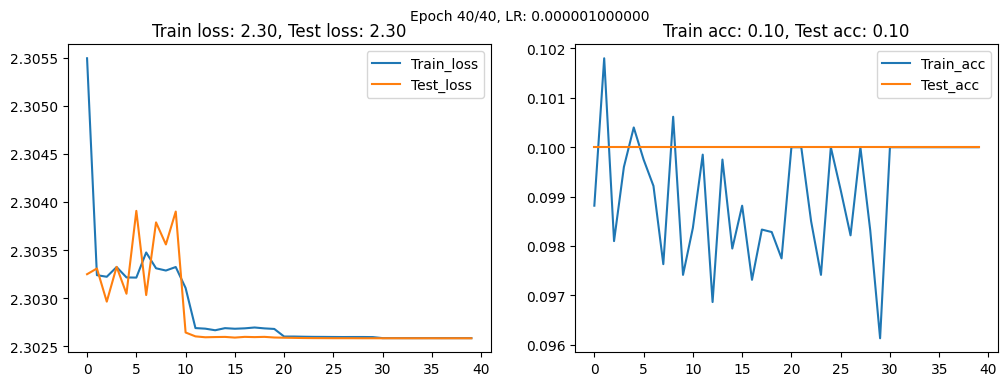

In [14]:
# Ненормализованные данные
bad_lm = LearningModel(LeNet(), train_loader, test_loader, device='auto')
bad_lm.learning_function(epochs=EPOCHS, loss_func=nn.NLLLoss())

Исходная модель на ненормализованных данных сразу идет в разнос.

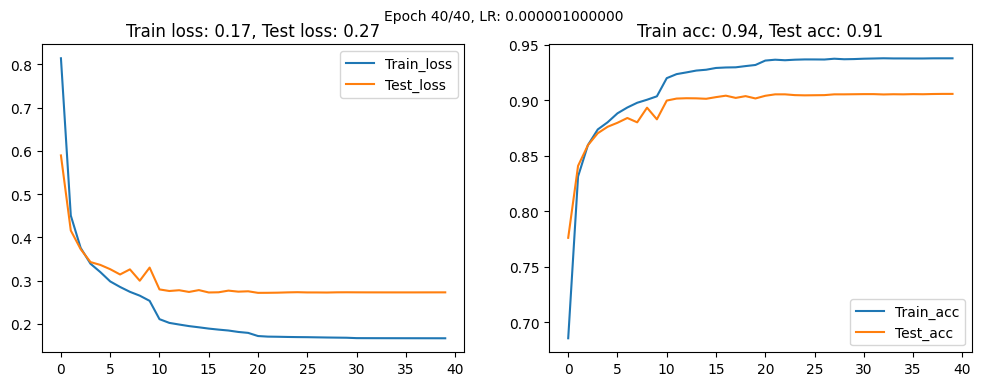

In [15]:
# Нормализованные данные
bad_lm_norm = LearningModel(LeNet(), train_loader_norm, test_loader_norm, device='auto')
bad_lm_norm.learning_function(epochs=EPOCHS, loss_func=nn.NLLLoss())

На нормализованных данных результаты лучше. Примерно с 25-й эпохи улучшение обучение практически заканчивается.

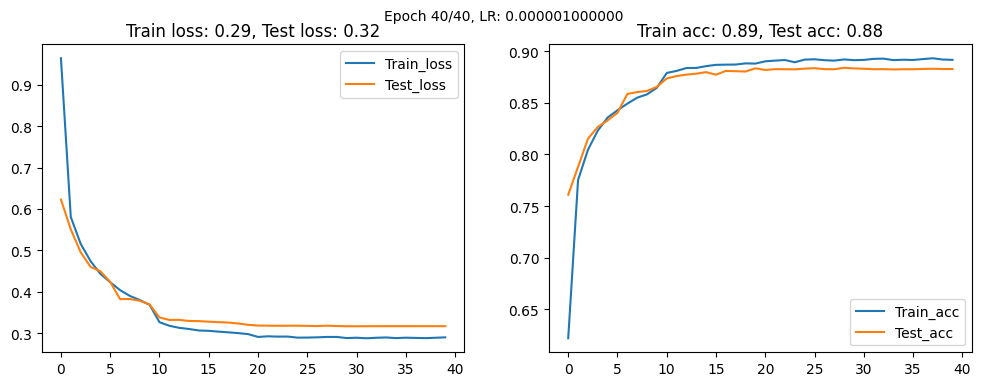

In [16]:
# Аугментация + нормализация данные
bad_lm_aug = LearningModel(LeNet(), train_loader_aug, test_loader_aug, device='auto')
bad_lm_aug.learning_function(epochs=EPOCHS, loss_func=nn.NLLLoss())

На нормализованных данных с аугментацией результаты похуже, чем с просто нормализацией. Что ожидаемо.
Добавление аугментации сблизило графики потерь на тренировочных и тестовых данных. При этом на тренировчных потери стали выше, чем с просто нормализацией.

## Обучение FashionLeNet()

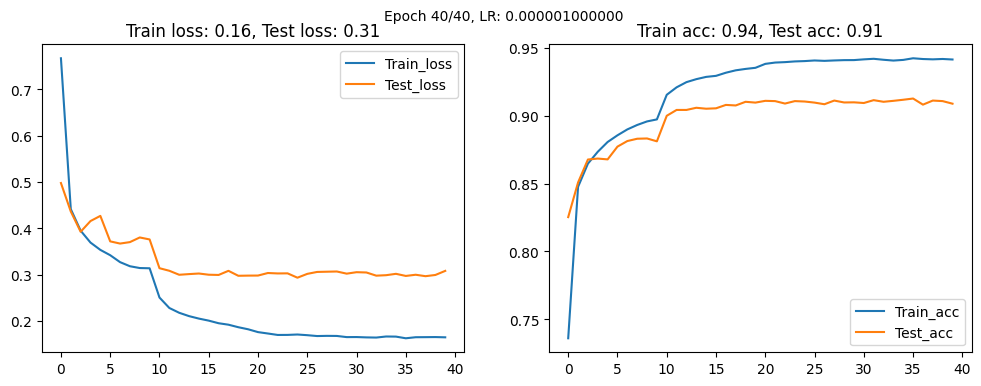

In [17]:
# Ненормализованные данные
fashion_lm = LearningModel(FashionLeNet(), train_loader, test_loader, device='auto')
fashion_lm.learning_function(epochs=EPOCHS, loss_func=nn.CrossEntropyLoss())

На удивление на ненормализованных данных результаты неплохие.

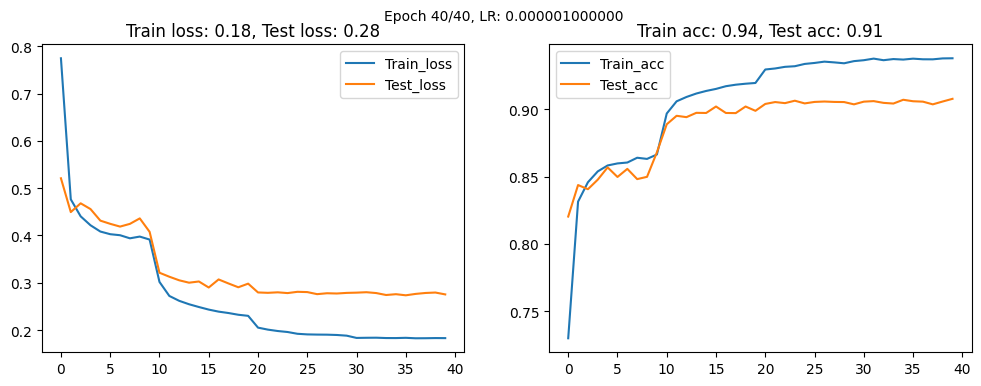

In [21]:
# Нормализованные данные
fashion_lm_norm = LearningModel(FashionLeNet(), train_loader_norm, test_loader_norm, device='auto')
fashion_lm_norm.learning_function(epochs=EPOCHS, loss_func=nn.CrossEntropyLoss(), weight_decay=0.001)

Нормализация данных практически не меняет результаты обучения. 

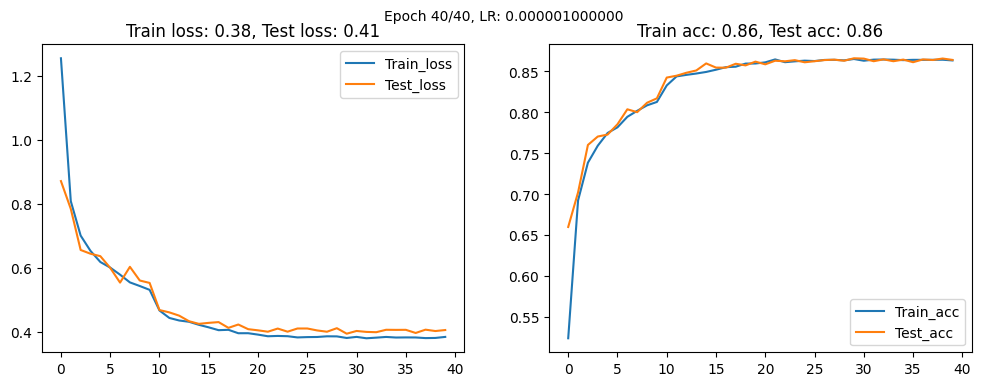

In [25]:
# Аугментация + нормализация данные
fashion_lm_aug = LearningModel(FashionLeNet(), train_loader_aug, test_loader_aug, device='auto')
fashion_lm_aug.learning_function(epochs=EPOCHS, loss_func=nn.CrossEntropyLoss(), weight_decay=0.0)

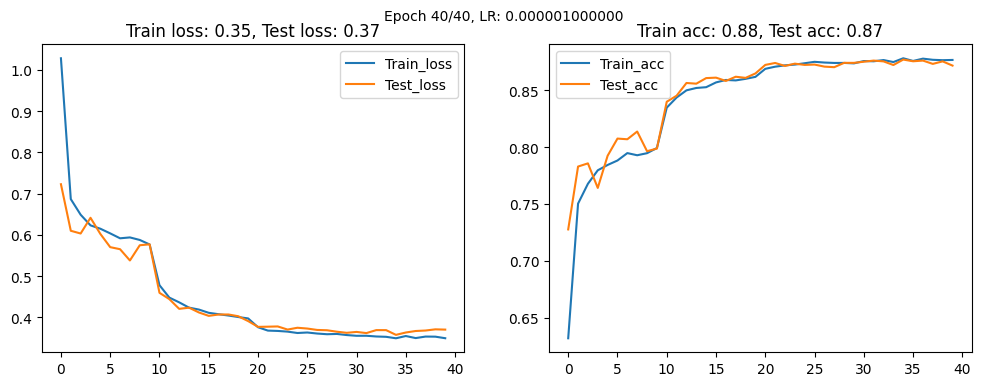

In [ ]:
# Аугментация + нормализация данные
fashion_lm_aug = LearningModel(FashionLeNet(), train_loader_aug, test_loader_aug, device='auto')
fashion_lm_aug.learning_function(epochs=EPOCHS, loss_func=nn.CrossEntropyLoss(), weight_decay=0.001)

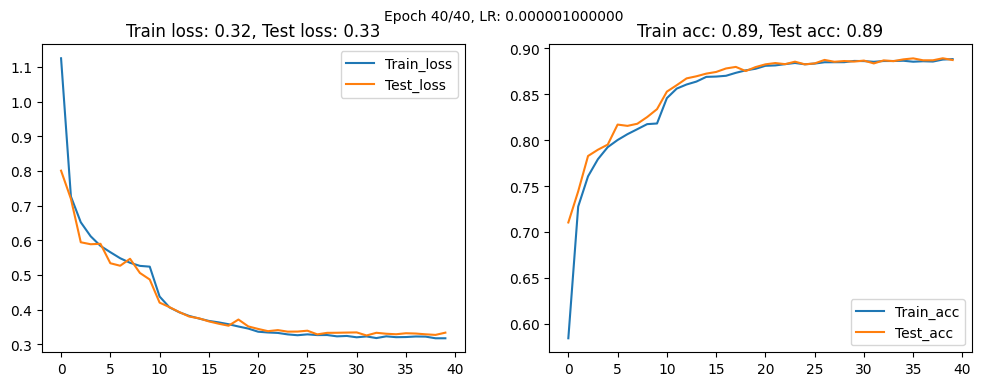

In [ ]:
# Аугментация + нормализация данные
fashion_lm_aug = LearningModel(FashionLeNet(), train_loader_aug, test_loader_aug, device='auto')
fashion_lm_aug.learning_function(epochs=EPOCHS, loss_func=nn.CrossEntropyLoss(), weight_decay=0.0001)